In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt

In [3]:
## ignore the future decpreciation warnings in CatBoost and RandomForest
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
df = pd.read_csv('data_modified.csv', low_memory=False)
df = df.drop(columns=['Unnamed: 0', 'Description', 'Reference number', 'Location', 'Functions'])
df = df.dropna()
print(df.shape)
df.head()

(46090, 29)


,Bracelet material,Brand,Case diameter,Case material,Condition,Dial,Gender,Model,Movement,Scope of delivery,...,Chronograph,GMT,Tachymeter,Moon phase,Annual calendar,Perpetual calendar,Tourbillon,Flyback,Alarm,Country
0,Steel,Bulgari,41.0,Steel,New,Black,Men's watch/Unisex,Octo,Automatic,"Original box, original papers",...,0,0,0,0,0,0,0,0,0,United States of America
1,Steel,Tissot,39.0,Steel,New,Mother of pearl,Men's watch/Unisex,PR 100,Quartz,"Original box, no original papers",...,0,0,0,0,0,0,0,0,0,Japan
2,Leather,Mido,41.0,Steel,New,Silver,Men's watch/Unisex,Belluna,Automatic,"Original box, original papers",...,0,0,0,0,0,0,0,0,0,Japan
3,Steel,Mido,42.0,Steel,New,Black,Men's watch/Unisex,Multifort GMT,Automatic,"Original box, original papers",...,0,0,0,0,0,0,0,0,0,Japan
4,Leather,Seiko,42.0,Steel,Unworn,Black,Men's watch/Unisex,Kinetic,Quartz,"Original box, original papers",...,0,0,0,0,0,0,0,0,0,Japan


# 1. Exploratory analysis

To see how suitable some of the features are to differentiate between different watch brands, I examine their distribution between the top 10 brands by number of offerings. <br>
I use the odds-ratio (OR) to determine how the values of a features impact the likelihood that a watch belongs to a certain brand. <br> 
The odds ratio is defined as the odds that a watch is of a given brand divided by the odds that a watch is of a given brand when the feature has a certain value. For example, if the brand is 'Omega' and the value of the feature 'Movement' is 'Manual winding', an Odds-ratio of 5 implies that a watch with a hand-wound movement is 5 times more likely to be an Omega compared to the base probability.

\begin{equation*}
OR^{>1} = \frac{R(Brand)}{R(Brand^{feat})}
\end{equation*}

A given feature-value can also decrease the odds of a certain brand to be present. The odds-ratio would then be between 0 and 1. <br>
To make this case more comparable, I modify Odds-ratios below 1 by taking the negative reciprocal. <br>
To follow the example above, if the brand is 'Rolex' and the value of the feature 'Movement' is 'Manual winding', an Odds-ratio of -4 implies that a watch with a hand-wound movement is 4 times less likely to be a Rolex compared to the base probability.

\begin{equation*}
OR^{<1} = -\frac{1}{OR^{>1}}
\end{equation*}

Lastly, there are also cases where a given brand never has a certain feature-value. Or alternatively, a given feature-value is only ever displayed by one specific brand. <br>
The odds-ratio would be zero in this case. I replace the odds-ratio with -999 or 999 respectively, to make this information more visible.

The individual features will probably increase their information value significantly when combined with other features. <br>
<br>
## Note
Sadly the colored dataframes are not displayed on github. <br>
The correct colors can be viewed here: https://nbviewer.jupyter.org/github/Ortgies/chrono/blob/main/classification.ipynb

In [5]:
## get the ten most frequent brands
print(df['Brand'].value_counts()[0:10])
top_brands = df['Brand'].value_counts()[0:10]

Rolex             13050
Omega              4438
Cartier            2107
Breitling          1943
Seiko              1917
TAG Heuer          1715
Longines           1484
Hublot             1227
Patek Philippe     1167
Tudor              1138
Name: Brand, dtype: int64


In [6]:
## calculate odds-ratio based on the formula above
def get_brand_dist(feature):
    t = pd.DataFrame(columns=df[feature].unique(), index=top_brands.index.values)
    
    for brand in top_brands.index.values:
        odd1 = len(df[df['Brand'] == brand]) / len(df[(df['Brand'].isin(top_brands.index.values)) & (df['Brand'] != brand)])
        r = []
        for value in df[feature].unique():
            ## exception if none of the top-10 brands have a certain feature value
            try:
                target = len(df[(df['Brand'] == brand) & (df[feature] == value)])
                rest = len(df[(df['Brand'].isin(top_brands.index.values)) & (df['Brand'] != brand) & (df[feature] == value)])
                
                if target == 0:
                    x = -999
                elif rest == 0:
                    x = 999
                else:
                    x = (target/rest)/odd1
                    if x < 1:
                        x = -1/x
            except:
                x = 0
            r.append(x)
        t.loc[brand] = r
    
    t = t.apply(pd.to_numeric)
    return(t)

In [7]:
## apply styling to the dataframe, red hues for reduced odds, green hues for increased odds
def centered_background_gradient(s):
    cmap = plt.cm.get_cmap('RdYlGn')
    norm = plt.colors.TwoSlopeNorm(vmin=-30, vcenter=0, vmax=30)
    return ['background-color: {:s}'.format(plt.colors.to_hex(c.flatten())) for c in cmap(norm(s.values))]

## 1.1 Movement
The type of movement offers some differentiation between brands. <br>
Automatic movements are the default, so the odds ratios are close to 1 in most cases. <br>
A quartz movement significantly increases the odds that a watch is made by Cartier. In contrast to this, Rolex and its daughter company Tudor have almost no quartz watches in their portfolio (Rolex has only produced a single quartz model in their history). <br>
A manually-wound watch is more likely to be an Omega, famous for their hand-wound Speedmaster, or one of the many hand-wound dress watches by Patek Phillipe.

In [8]:
get_brand_dist('Movement').style.apply(centered_background_gradient)

,Automatic,Quartz,Manual winding
Rolex,1.382586,-33.796308,-4.582402
Omega,-1.217173,-1.026445,5.880307
Cartier,-2.020800,5.357727,1.356001
Breitling,1.015900,1.110050,-1.904558
Seiko,-1.091823,1.911581,-2.849922
TAG Heuer,-1.327220,3.351334,-8.147018
Longines,-1.262322,3.002324,-12.024807
Hublot,1.099246,-1.617205,-2.523384
Patek Philippe,-1.259966,-1.249786,5.205007
Tudor,1.210269,-14.538412,-15.974232


## 1.2 Crystal
As with the movement, the default value, a sapphire crystal, offers little information for separating brands. <br>
Mineral glass is rarely found in the second most expensive brand on this list, Rolex. The use of mineral glass increases the odds that a watch is made by Seiko, the most affordable brand on this list fourty-fold. <br>
Plexiglass is used by most manufacturers, mostly in vintage models. Hublot, the youngest brand on the list does not have a single watch with a plexiglass crystal, signified by the OR of -999.

In [9]:
get_brand_dist('Crystal').style.apply(centered_background_gradient)

,Sapphire crystal,Mineral Glass,Plexiglass
Rolex,1.042205,-53.133080,1.190534
Omega,-1.237836,-1.429393,4.054840
Cartier,1.088532,1.321508,-15.134645
Breitling,1.106615,-2.568377,-5.110546
Seiko,-1.465228,39.089873,-2.448902
TAG Heuer,1.118499,-9.176062,-5.608470
Longines,1.108028,-11.840151,-3.630439
Hublot,1.137017,-12.951172,-999.000000
Patek Philippe,1.101876,-2.272149,-5.005814
Tudor,1.038375,-8.971427,-1.070825


## 1.3 Materials
Case and bracelet materials are very useful for separating brands. <br>
While common materials like steel and yellow gold are used by all brands to some extent, there are a lot of materials that are used by only a few manufacturers. For most materials you have at least one brand with a very high odds-ratio and multiple ones with the minimum value of -999. <br>
For example only five brands use platinum cases and only two platinum bracelets. <br>
Aluminium cases are used exclusively by Seiko which makes classification easy in this case.

In [10]:
get_brand_dist('Case material').style.apply(centered_background_gradient)

,Steel,Gold/Steel,Yellow gold,Titanium,Platinum,Rose gold,White gold,Ceramic,Bronze,Carbon,Plastic,Silver,Aluminum,Other
Rolex,-1.088768,2.996996,1.688069,-999.000000,1.545805,-1.561101,1.445276,-176.680672,-999.000000,-999.000000,-999.000000,-11.677171,-999,-999
Omega,1.221180,-1.620956,-2.103486,-1.090666,-9.709777,-1.743572,-5.956096,1.275769,-1.964937,-2.843988,-9.479960,-4.050528,-999,-999
Cartier,-1.351104,1.278065,2.895371,-999.000000,-3.151608,1.499097,2.487399,-999.000000,-999.000000,-5.177642,-999.000000,25.085234,-999,-999
Breitling,1.135892,-1.212479,-4.125725,1.989903,-999.000000,-1.499515,-999.000000,-31.990051,-999.000000,3.007401,392.465775,-6.673193,-999,-999
Seiko,1.372111,-16.260540,-13.989780,2.444603,-999.000000,-30.334925,-65.032474,-4.446582,-999.000000,-999.000000,-999.000000,-999.000000,999,-999
TAG Heuer,1.359211,-6.708364,-31.157450,1.562218,-999.000000,-11.513821,-999.000000,1.101679,-1.807102,1.277013,-3.313020,-999.000000,-999,-999
Longines,1.265969,-1.657053,-3.010633,-3.705433,-999.000000,-1.107321,-999.000000,-24.042227,2.072247,-999.000000,-999.000000,-999.000000,-999,-999
Hublot,-4.789243,-6.759063,-6.231453,18.228775,-7.245312,6.317452,-20.295349,40.715981,-2.584585,51.494110,-999.000000,-999.000000,-999,-999
Patek Philippe,-2.699185,-15.022548,3.787311,-999.000000,17.480287,5.237372,10.033780,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999,-999
Tudor,1.167833,-2.550316,-8.984485,1.785218,-999.000000,-999.000000,-999.000000,2.863240,87.515943,-999.000000,-999.000000,7.827815,-999,-999


In [11]:
get_brand_dist('Bracelet material').style.apply(centered_background_gradient)

,Steel,Leather,Gold/Steel,Rubber,Titanium,Yellow gold,Platinum,Textile,Rose gold,White gold,Ceramic,Aluminium,Silver
Rolex,1.315856,-7.520352,4.640224,-6.424810,-999.000000,3.874265,36.329195,-98.240546,1.628248,3.885162,-999.000000,-999,-1.903887
Omega,1.143319,1.481145,-3.487622,-1.369212,1.489328,-3.493221,-999.000000,1.497216,-2.490347,-2.979416,-4.481435,-999,2.320685
Cartier,-1.698465,2.296879,1.332653,-2.183208,-999.000000,1.924279,-999.000000,-4.105666,1.025118,1.903790,-999.000000,-999,-999.000000
Breitling,-1.311968,1.720905,-4.456889,3.143727,2.076538,-12.471697,-999.000000,2.386470,-3.013256,-999.000000,-1.788691,-999,2.422628
Seiko,1.172581,-1.061145,-37.850844,1.187732,7.440884,-999.000000,-999.000000,6.015712,-999.000000,-999.000000,-999.000000,-999,5.898592
TAG Heuer,1.155957,1.286706,-7.157415,1.442171,1.020784,-12.750108,-999.000000,1.185798,-999.000000,-999.000000,5.263784,-999,-999.000000
Longines,-1.066157,1.993425,-1.325010,-1.968369,-5.601236,-5.945927,-999.000000,-3.309038,1.094772,-999.000000,-1.344297,-999,-999.000000
Hublot,-98.238445,1.602713,-47.341690,11.023347,2.375987,-999.000000,-999.000000,3.550663,2.898426,-999.000000,43.476387,-999,-999.000000
Patek Philippe,-3.257621,3.448844,-11.203238,1.566756,-999.000000,1.619009,-1.112616,-5.187739,3.552332,1.955778,-999.000000,-999,-999.000000
Tudor,1.205073,1.090495,-2.538025,-2.869028,5.483252,-999.000000,-999.000000,3.413291,-999.000000,-999.000000,-999.000000,-999,-999.000000


## 1.4 Functions

In [12]:
get_brand_dist('Perpetual calendar').style.apply(centered_background_gradient)

,0,1
Rolex,-1.008350,2.074904
Omega,1.010889,-6.300822
Cartier,1.011667,-25.287902
Breitling,1.005986,-2.045112
Seiko,1.007589,-2.797278
TAG Heuer,1.012014,-999.000000
Longines,-1.011875,2.092630
Hublot,1.009230,-4.731344
Patek Philippe,-1.050010,6.033740
Tudor,1.011773,-999.000000


In [13]:
get_brand_dist('Tourbillon').style.apply(centered_background_gradient)

,0,1
Rolex,1.002340,-999.000000
Omega,1.001556,-999.000000
Cartier,1.001427,-999.000000
Breitling,1.001418,-999.000000
Seiko,1.001417,-999.000000
TAG Heuer,-1.014258,27.668610
Longines,1.001396,-999.000000
Hublot,-1.008036,8.952281
Patek Philippe,-1.000405,1.308754
Tudor,-1.000450,1.343446


# 2. Feature Engineering

In [14]:
df = df[df["Year of production"] > 1900]
df['Decade'] = 0
for i in range(190, 220):
    start = i * 10
    end = start + 10
    df.loc[(df['Year of production'] >= start) & (df['Year of production'] < end), 'Decade'] = '{}s'.format(start)

In [15]:
df = df.loc[df['Case diameter'] > 14]
df['Diameter_group'] = 0
for i in range(0, 24):
    start = 14 + i*2
    end = start + 1
    df.loc[(df['Case diameter'] >= start) & (df['Case diameter'] <= end), 'Diameter_group'] = '{}-{}'.format(start, end)

In [16]:
keep = df['Brand'].value_counts()
keep = keep[keep>4]
keep = keep.index.get_level_values(0).astype(str).values
df = df[df['Brand'].isin(keep)]

In [17]:
df = df.dropna()

# 3. Feature Based Classification

In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV, ParameterGrid
from category_encoders.binary import BinaryEncoder
from category_encoders.target_encoder import TargetEncoder
from catboost import CatBoostClassifier, Pool
import time

In [19]:
categorical_var = ['Bracelet material', 'Case material',
       'Condition', 'Dial', 'Gender', 'Movement', 'Scope of delivery',
       'private_seller', 'Crystal', 'Decade', 'Diameter_group', 'Country']

In [20]:
functions = ['Date', 'Weekday', 'Month', 'Year', 'Chronograph', 'GMT', 
             'Tachymeter', 'Moon phase', 'Annual calendar', 'Perpetual calendar',
             'Tourbillon', 'Flyback', 'Alarm']

In [21]:
X = df[categorical_var + functions]
y = df['Brand']

## 3.1 First test of different classifiers
In the first step, the categorical data has to be numerically encoded. <br>
The default solution is a onehot dummy encoding. As a downside, this will result in a very large number of variables, making the regression much slower. <br>
Binary encoding is a viable alternative resulting in significantly less variables. On the flipside, this method will have some information loss compared to dummy encoding. In addition, the logistic regression model will have some problems with binary encoding, as it does not natively take variable interactions into account. With tree based models this problem is alleviated. <br>
I test out three classification models:
1. A simple logistic regression model
2. A K-nearest Neighbours model
3. A decision-tree ensemble model (Random Forest)
<br>
<br>
The baseline results are quite promising, the three classification models have accuracies of 53%, 56% and 61% respectively. <br>
As in the regression problem, the Random Forest model delivers the best results, but it is quite slow with onehot encoding. <br>
Using binary encoding we can observe a trade-off of 1% drop in accuracy for a 4 time speed-up of the calculation.

In [22]:
%%time

transformers = [
    ColumnTransformer([('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_var)], remainder='passthrough'),
    ColumnTransformer([('binary', BinaryEncoder(), categorical_var)], remainder='passthrough'),
]

models = [
    LogisticRegression(random_state=13, max_iter=1000),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=13),
]


for transformer in transformers:
    print(transformer.transformers[0][0])
    for model in models:
        start_time = time.time()
        pipe = Pipeline([('tf', transformer), ('model', model)])
        scores = cross_val_score(pipe, X, y, cv=5, n_jobs=5)
        print('{}. Score: {}. Time: {}s'.format(model, np.mean(scores), time.time() - start_time))

onehot
LogisticRegression(max_iter=1000, random_state=13). Score: 0.5301291562105177. Time: 244.98690223693848s
KNeighborsClassifier(). Score: 0.5568217284050645. Time: 15.981045246124268s
RandomForestClassifier(random_state=13). Score: 0.6137308273896627. Time: 43.983306646347046s
binary
LogisticRegression(max_iter=1000, random_state=13). Score: 0.4787891478371587. Time: 333.80410623550415s
KNeighborsClassifier(). Score: 0.5367643250138233. Time: 10.873936891555786s
RandomForestClassifier(random_state=13). Score: 0.6021794064919821. Time: 10.155503988265991s
Wall time: 10min 59s


## 3.2 Gradient boosting
It might be possible to increase accuracy even more with gradient boosting. <br>
I use the CatBoost algorithm as an implementation of gradient boosting. The catboost package comes with two very useful features. First of all it supports calculation on GPU natively, which significantly speeds of calculation. Secondly, encoding is handled internally and allows for easy output of feature importance. <br>
<br>
After 1000 iterations, CatBoost achieves an accuracy of 62%. The results are comparable to the Random Forest classifier, but the calculation is significantly slower. <br>
Case diameter is by far the most important feature. <br>
It is surprising to see the selling country to have such a high importance. 

In [23]:
df['private_seller'] = df['private_seller'].astype(int)
X = df[categorical_var + functions]

In [24]:
%%time

model = CatBoostClassifier(cat_features=categorical_var, iterations=1000, random_state=13, task_type='GPU', devices='0:1', early_stopping_rounds=10, verbose=False)
np.mean(cross_val_score(model, X, y, cv=5, n_jobs=1))

Wall time: 13min 26s


0.6169069891991337

In [25]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
model.fit(X_train, y_train)

Wall time: 2min 38s


Wall time: 410 ms


<AxesSubplot:xlabel='feature', ylabel='importance'>

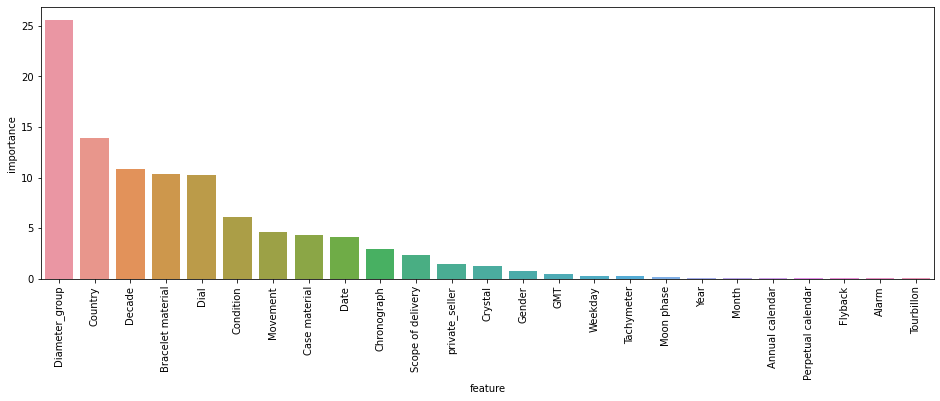

In [26]:
%%time

pool = Pool(X_train, label=y_train, cat_features=categorical_var)
fi = model.get_feature_importance(pool)

df_fi = pd.DataFrame({
    'feature': X.columns,
    'importance': fi
})

plt.pyplot.figure(figsize=(16,5))
plt.pyplot.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=df_fi.sort_values('importance', ascending=False))

## 3.3 Hyperparameter tuning for Random Forest
The random forest regression has delivered the best results so far. <br>
I try to optimize the model by tuning the hyperparameters. Since the model takes a fairly long time to run, I use a randomized search grid. <br>
With the optimized parameters, the model improves only slightly by 0.03%. The base parameters seem to be very close to ideal already.

In [27]:
%%time

params = [
    {'model__max_depth': [50, 100, 200, None],
     'model__max_features': ['log2', 'auto'],
     'model__min_samples_leaf': [1, 2],
     'model__min_samples_split': [2, 5, 10],
     'model__n_estimators': [100, 200, 500]}]


transformer = ColumnTransformer([
        ('cat', BinaryEncoder(), categorical_var),
    ], remainder='passthrough')


pipe = Pipeline([('tf', transformer), ('model',RandomForestClassifier(random_state=13, n_jobs=5))])

grid = RandomizedSearchCV(estimator=pipe,
             param_distributions=params, n_jobs=1, n_iter=100, cv=3, verbose=1, random_state=13)

grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'model__n_estimators': 500, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'auto', 'model__max_depth': 200}
0.5944568996088176
Wall time: 32min 10s


In [29]:
transformer = ColumnTransformer([('binary', BinaryEncoder(), categorical_var)], remainder='passthrough')

pipe = Pipeline([('tf', transformer), ('model',RandomForestClassifier(random_state=13, n_jobs=5, 
                                       n_estimators= 500, 
                                       min_samples_split=5,
                                       min_samples_leaf=1,
                                       max_features='auto',
                                       max_depth = 200))])


np.mean(cross_val_score(pipe, X, y, cv=5, n_jobs=5))

0.6079008460462144

# 4. Image based classification
The offerings on Chrono24 usually contain a picture of the watch. <br>
In an earlier step I have used text recongnition to extract words that are present on the watch dial. Since recognition is often times imperfect, the resulting words have been clustered by similarity. For example, Rolex, olex, Role or Boiex would all be in the same cluster. <br>
I use the occurence of clusters in each watch as the features for a second classification.

In [30]:
df_words = pd.read_csv('word_clusters.csv', low_memory=False)
df = df.merge(df_words, on='id')

X = df[map(str, range(0, 389))]
y = df['Brand']

## 4.1 First test of different classifiers
The K-nearest neighbors classifier seems to have problems with the sparse binary dataset and results in an accuracy of just 41%. <br>
A logistic regression and a random forest model have significantly better results of 57% and 55% respectively. <br>

In [31]:
%%time

models = [
    LogisticRegression(random_state=13, max_iter=1000),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=13),
]


for model in models:
    start_time = time.time()
    scores = cross_val_score(model, X, y, cv=5, n_jobs=5)
    print('{}. Score: {}. Time: {}s'.format(model, np.mean(scores), time.time() - start_time))

LogisticRegression(max_iter=1000, random_state=13). Score: 0.5656471125313856. Time: 92.67591071128845s
KNeighborsClassifier(). Score: 0.4074640493038119. Time: 12.81178617477417s
RandomForestClassifier(random_state=13). Score: 0.55243095183748. Time: 34.621960163116455s
Wall time: 2min 20s


## 4.2 Gradient boosting
CatBoost has an accuracy of 56%. But it is again very time intensive.

In [33]:
%%time

model = CatBoostClassifier(random_state=13, depth = 8,
    loss_function='MultiClass', eval_metric = 'Accuracy', task_type='GPU', devices='0:1', early_stopping_rounds=10, verbose=False)


np.mean(cross_val_score(model, X, y, cv=5, n_jobs=1))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Wall time: 9min 28s


0.5676557863501484

## 4.3 Hyperparameter tuning for random forest
The logistic regression performed slightly better than the random forest classifier, but its runtime is also almost three times as long. <br>
I try tuning the hyperparameters of the random forest model to improve performance. <br>
Using a randomized search grid, I was able to find hyper parameters that increase performance to 57%, marginally overtaking the logistic regression.

In [34]:
%%time

params = [
    {'max_depth': [200, 500, None],
     'max_features': ['auto', 'log2'],
     'min_samples_leaf': [1, 2],
     'min_samples_split': [2, 20, 50],
     'n_estimators': [100, 200, 500]}]



grid = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=13, n_jobs=5),
             param_distributions=params, n_jobs=1, n_iter=100, cv=3, verbose=1, random_state=13)

grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 200}
0.5628397402161429
Wall time: 56min 52s


In [37]:
%%time

model = RandomForestClassifier(random_state=13, n_jobs=1, 
                                       n_estimators= 200, 
                                       min_samples_split=20,
                                       min_samples_leaf=1,
                                       max_features='log2',
                                       max_depth = 200)


np.mean(cross_val_score(model, X, y, cv=5, n_jobs=5))

Wall time: 39.2 s


0.5656699383702352

# 5 Ensemble models
## 5.1 Voting classifier
First, I will use a simple voting classifier. <br>
The combination of feature and image based classification results in a significant increase in accuracy. On their own they have achieved an accuracy of 60% and 57% respectively, but as an ensemble accuracy is increased to 71%.

In [39]:
X = df
y = df['Brand']

In [40]:
%%time

n_cols = len(df[categorical_var + functions].columns)

m1 = RandomForestClassifier(random_state=13, n_jobs=5, n_estimators=500, min_samples_split=5, min_samples_leaf=1, max_features= 'auto', max_depth=200)
m2 = RandomForestClassifier(random_state=13, n_jobs=5, n_estimators=200, min_samples_split=20, min_samples_leaf=1, max_features= 'log2', max_depth=200)


pipe_1 = Pipeline([
    ('selector', ColumnTransformer([('selector', 'passthrough', categorical_var + functions)], remainder='drop')),
    ('encoder', ColumnTransformer([('encoder', BinaryEncoder(), list(range(0,n_cols)))], remainder='passthrough')),
    ('model', m1)
])

pipe_2 = Pipeline([
    ('selector', ColumnTransformer([('selector', 'passthrough', list(map(str, range(0, 389))))], remainder='drop')),
    ('model', m2)
])


clf = VotingClassifier(estimators=[('m1', pipe_1), ('m2', pipe_2)], voting='soft')

np.mean(cross_val_score(clf, X, y, cv=5, n_jobs=1))

Wall time: 2min


0.7110477060031956

## 5.2 Stacking Classifier
Instead of a simple voting classifier, a third regression can be used to get a more precise prediction. <br>
I use a logistic regression to classify brands based on the results of the feature and image classification. <br>
Accuracy improves compared to the voting classifier to 73%.

In [41]:
%%time

models = [('m1', pipe_1),
          ('m2', pipe_2)]

clf = StackingClassifier(estimators=models, final_estimator=LogisticRegression(n_jobs=5))

np.mean(cross_val_score(clf, X, y, cv=5, n_jobs=1))

Wall time: 12min 22s


0.7366126455147227

# 6 Exkursions
## 6.1 Binary Classification
It would be interesting to see how well the models I developed above are able to spot a Rolex. <br>
To save time, I use the same models and hyper parameters as before instead of repeating all steps. <br>
The models works incredibly well, separating Rolex and other brands with an accuracy of 96%.

In [42]:
X = df
y = df['Brand'] == 'Rolex'

In [43]:
%%time

n_cols = len(df[categorical_var + functions].columns)

m1 = RandomForestClassifier(random_state=13, n_jobs=5, n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features= 'auto', max_depth=None)
m2 = RandomForestClassifier(random_state=13, n_jobs=5, n_estimators=500, min_samples_split=20, min_samples_leaf=1, max_features= 'log2', max_depth=200)


pipe_1 = Pipeline([
    ('selector', ColumnTransformer([('selector', 'passthrough', categorical_var + functions)], remainder='drop')),
    ('encoder', ColumnTransformer([('encoder', BinaryEncoder(), list(range(0,n_cols)))], remainder='passthrough')),
    ('model', m1)
])

pipe_2 = Pipeline([
    ('selector', ColumnTransformer([('selector', 'passthrough', list(map(str, range(0, 389))))], remainder='drop')),
    ('model', m2)
])

models = [('m1', pipe_1),
          ('m2', pipe_2)]

clf = StackingClassifier(estimators=models, final_estimator=LogisticRegression(n_jobs=5))

np.mean(cross_val_score(clf, X, y, cv=5, n_jobs=1))

Wall time: 6min 12s


0.9567222095412007